# Introduction

The purpose of the project is to analyse tweets to determine peoples viees or sentiment on climate change. Sentiment analysis is the interpretation and classification of emotions, within text data, utilising text analysis techniques. The prediction would aid companies on providing robust solutions and marketing strategies based on customers sentiment

**Contents**
1. Importing Packages
2. Importing datasets
3. Exploratory Data Analysis
4. Text pre-processing
5. Splitting the data
6. Vector Transformation
7. Creating and Evaluating the models
8. CSV submission

# **Importing Packages**

In [1]:
#utility packages
import re
import numpy as np
import pandas as pd
import emoji
import string

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#set plt style
sns.set()

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Importing Datsets

The datasets imported are the train and test datasets for this competition. It contains tweets and tweet_ids  

The train dataset consists of 15819 rows with three columns (sentiment, message and tweetid)

The test dataset consists of  10546 rows with two columns ( message and tweetid)

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/climate-change-edsa2020-21/train.csv
/kaggle/input/climate-change-edsa2020-21/test.csv
/kaggle/input/climate-change-edsa2020-21/sample_submission.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/climate-change-edsa2020-21/train.csv")
train_data.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
print(train_data.shape)
train_data.info()

(15819, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [5]:
test_data = pd.read_csv("/kaggle/input/climate-change-edsa2020-21/test.csv")
test_data.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [6]:
print(test_data.shape)
test_data.info()

(10546, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


# Exploratory Data Analysis

Count the number of words in each dataset

To identify the number of words in each tweet 

In [7]:
def num_of_words(df):
    train_data['word_count'] = train_data['message'].apply(lambda x : len(str(x).split(" ")))
    print(train_data[['message','word_count']].head())

In [8]:
num_of_words(train_data)

                                             message  word_count
0  PolySciMajor EPA chief doesn't think carbon di...          19
1  It's not like we lack evidence of anthropogeni...          10
2  RT @RawStory: Researchers say we have three ye...          19
3  #TodayinMaker# WIRED : 2016 was a pivotal year...          15
4  RT @SoyNovioDeTodas: It's 2016, and a racist, ...          18


In [9]:
def num_of_words(df):
    test_data['word_count'] = test_data['message'].apply(lambda x : len(str(x).split(" ")))
    print(test_data[['message','word_count']].head())

In [10]:
num_of_words(train_data)

                                             message  word_count
0  Europe will now be looking to China to make su...          20
1  Combine this with the polling of staffers re c...          20
2  The scary, unimpeachable evidence that climate...          14
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...          23
4  RT @FakeWillMoore: 'Female orgasms cause globa...           8


Frequency of each word in a tweet

In [11]:
#generate a word frequency
def gen_freq(text):
    #store the list of words
    word_list=[]
    
    #Loop over all the tweets and extract wotds into a word_list
    for tw_words in text.split():
        word_list.extend(tw_words)
        
    #create word frequencies using a word list
    word_freq = pd.Series(word_list).value_counts()
    
    #Print top 5 words
    word_freq[:5]
    
    return word_freq

gen_freq(train_data.message.str)

climate             12170
RT                   9706
change               8865
to                   7066
the                  6397
                    ...  
Chicago.                1
@AndersEigen            1
why:…                   1
@SteveEngland300        1
'international          1
Length: 47508, dtype: int64

In [12]:
#generate a word frequency
def gen_freq(text):
    #store the list of words
    word_list=[]
    
    #Loop over all the tweets and extract wotds into a word_list
    for tw_words in text.split():
        word_list.extend(tw_words)
        
    #create word frequencies using a word list
    word_freq = pd.Series(word_list).value_counts()
    
    #Print top 5 words
    word_freq[:5]
    
    return word_freq

gen_freq(test_data.message.str)

climate                    8157
RT                         6367
change                     5931
to                         4738
the                        4293
                           ... 
Establishment:                1
Minnesota                     1
tainted                       1
47)                           1
https://t.co/PRFpiM7pyj       1
Length: 35460, dtype: int64

Sentiment analysis of the train and test datasets

In [13]:
temp = train_data.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,message
2,1,8530
3,2,3640
1,0,2353
0,-1,1296


[Text(0, 0, 'Negative'),
 Text(0, 0, 'Neutral'),
 Text(0, 0, 'Positive'),
 Text(0, 0, 'Compound')]

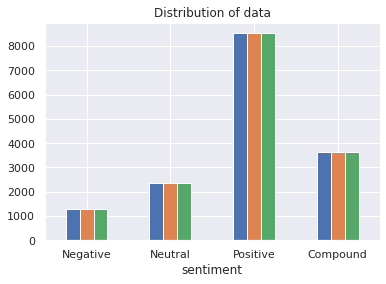

In [14]:
# Plotting the distribution for train dataset.
ax = train_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Neutral','Positive','Compound'], rotation=0)

In [15]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(train_data.loc[0]['message'])

{'neg': 0.0, 'neu': 0.905, 'pos': 0.095, 'compound': 0.2244}

From the above visualisation, the positive sentiment is much higher than the negative sentiment.

Before we perform any preprocessing, the two data frames will be concatenated

In [16]:
df= pd.concat([train_data, test_data], sort = True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26365 entries, 0 to 10545
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   message     26365 non-null  object 
 1   sentiment   15819 non-null  float64
 2   tweetid     26365 non-null  int64  
 3   word_count  26365 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.0+ MB


In [17]:
# concatenated dataframe stats
df.describe()

,sentiment,tweetid,word_count
count,15819.000000,26365.000000,26365.000000
mean,0.917504,499791.634971,17.622113
std,0.836537,288678.408660,4.422867
min,-1.000000,6.000000,1.000000
25%,1.000000,249928.000000,15.000000
50%,1.000000,499577.000000,18.000000
75%,1.000000,748695.000000,21.000000
max,2.000000,999983.000000,31.000000


# Text Data Preprocessing

Text preprocessing is essential to transform the text into a format that improves the performance of the machine learning algorithm 

The following steps were executed for text preprocessing

1. Fill in missing values in the test_data dataframe sentiment column
2. Defining a dictionary of stop words in english
3. Assign all text in lower case
4. Replacing all websites
5. Removal of @mention
6. Removal of punctuation in the data
7. Removal of numeric charecters
8. Removal of emoji's
9. Remove short words


Filling in the missing values in the sentiment column(test data frame)

In [18]:
# filling in the missing values in the dataframe, replaced with sentiment score of 0- neutral
df['sentiment'].fillna(0, inplace = True)

Defining a dictionary of stop words in english

In [19]:
#defining a list containing all stopwords in english
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

All text in lower case

In [20]:
#lowercase text
df['message'] = df['message'].str.lower()

print(df['message'].iloc[0])

polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yelvcefxkc via @mashable


Removal of website and url's, punctuation, names, non alpha-numeric charecters, separate the word with a single space

In [21]:
def clean_text(message):
    line = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",message).split()
    return " ".join (line)

df['message']=df['message'].apply(lambda x: clean_text(x))

print(df['message'].iloc[0])
print(df['message'].iloc[3])

polyscimajor epa chief doesn t think carbon dioxide is main cause of global warming and wait what via
todayinmaker wired 2016 was a pivotal year in the war on climate change


Removal of numeric charecters

In [22]:
# remove numeric charecters
def only_words(message):
    line=re.findall(r'\b[^\d\W]+\b', message)
    return " ".join(line)

df['message']=df['message'].apply(lambda x : only_words(x))

print(df['message'].iloc[3])

todayinmaker wired was a pivotal year in the war on climate change


Removal of emoji's

In [23]:
#find emoji and remove it:
def remove_emoji(message):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', message)

print (df['message'].iloc[15])

rt i don t wanna live forever and nothing will because climate change


Removing Shortwords

In [24]:
df['message'] = df['message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

print(df['message'].iloc[4])

racist sexist climate change denying bigot leading polls electionnight


Identify all the unique words

In [25]:
from collections import Counter
total_words = Counter()
df['message'].str.split().apply(total_words.update)
print(total_words)

Counter({'climate': 21717, 'change': 21209, 'global': 6357, 'warming': 5943, 'trump': 4082, 'about': 2969, 'that': 2871, 'believe': 1938, 'this': 1844, 'will': 1622, 'have': 1613, 'with': 1601, 'doesn': 1427, 'from': 1378, 'real': 1248, 'world': 1221, 'your': 1211, 'what': 1140, 'going': 1103, 'people': 1034, 'just': 985, 'because': 968, 'more': 950, 'president': 897, 'science': 819, 'they': 812, 'fight': 808, 'hoax': 806, 'like': 746, 'there': 724, 'says': 716, 'scientists': 700, 'over': 637, 'when': 625, 'here': 624, 'donald': 617, 'think': 612, 'thinking': 575, 'https': 558, 'china': 534, 'husband': 525, 'against': 520, 'action': 508, 'could': 507, 'news': 503, 'need': 484, 'right': 475, 'know': 475, 'than': 469, 'make': 468, 'pruitt': 457, 'should': 442, 'would': 437, 'energy': 430, 'thinks': 430, 'earth': 421, 'stop': 420, 'only': 412, 'obama': 400, 'weather': 400, 'elect': 394, 'made': 392, 'years': 388, 'planet': 387, 'carbon': 381, 'time': 377, 'scott': 372, 'paris': 368, 'stil

Word Cloud demonstrating the worfs in the data frame

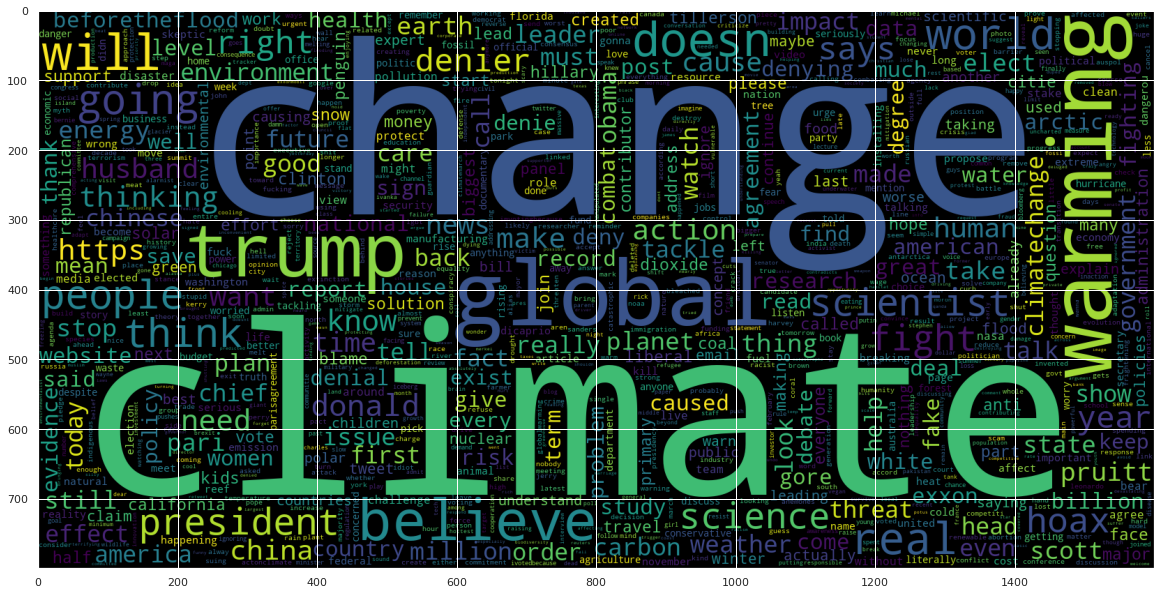

In [26]:
words = df['message']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(words))
plt.imshow(wc)

In [27]:
df.head()

,message,sentiment,tweetid,word_count
0,polyscimajor chief doesn think carbon dioxide ...,1.0,625221,19
1,like lack evidence anthropogenic global warming,1.0,126103,10
2,researchers have three years climate change be...,2.0,698562,19
3,todayinmaker wired pivotal year climate change,1.0,573736,15
4,racist sexist climate change denying bigot lea...,1.0,466954,18


In [28]:
df.drop(['word_count'], axis = 1)

,message,sentiment,tweetid
0,polyscimajor chief doesn think carbon dioxide ...,1.0,625221
1,like lack evidence anthropogenic global warming,1.0,126103
2,researchers have three years climate change be...,2.0,698562
3,todayinmaker wired pivotal year climate change,1.0,573736
4,racist sexist climate change denying bigot lea...,1.0,466954
...,...,...,...
10541,writing poem about climate change climatechang...,0.0,895714
10542,year climate change came home during hottest y...,0.0,875167
10543,vanuatu pacific countries positive about fiji ...,0.0,78329
10544,must cause global warming aldublaboroflove,0.0,867455


# Splitting the data

Split the concatenated dataframes

In [29]:
y = df[:len(train_data)][['sentiment']]
yt = df[len(train_data):][['sentiment']]
X = df[:len(train_data)].drop('sentiment', axis =1)['message']
Xt = df[len(train_data):].drop('sentiment', axis =1)

In [30]:
Xt

,message,tweetid,word_count
0,europe will looking china make sure that alone...,169760,20
1,combine this with polling staffers climate cha...,35326,20
2,scary unimpeachable evidence that climate chan...,224985,14
3,putin jill trump doesn believe climate change ...,476263,23
4,female orgasms cause global warming sarcastic ...,872928,8
...,...,...,...
10541,writing poem about climate change climatechang...,895714,15
10542,year climate change came home during hottest y...,875167,19
10543,vanuatu pacific countries positive about fiji ...,78329,16
10544,must cause global warming aldublaboroflove,867455,16


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score

from sklearn import preprocessing
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# For precision, recall, etc.
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB

# Vector Transformation

Text feature extraction is used to convert the text data into a matrix(or vector) of features. The count vectorizer converts a collection of documents (rows of text) into a matrix of token counts.

The following parameters are applies to fine tune the vector:

1. Stop words, specified as 'english'- any words in this list will be removed
2. n_gram range- The lower and upper boundary ranges of n-values for different n-grams to be extracted
3. max_df - When building the vocabulary, ignores terms that have a document frequency higher than the given threshold
4. min_df - When buidling the vocabulary, ignore terms that have a document frequency lower than the given threshold

In [32]:
vectorizer = CountVectorizer(stop_words = 'english',
                             min_df =1,
                             max_df = 0.5,
                             ngram_range= (1,2))

In [33]:
from sklearn.preprocessing import LabelEncoder
lbl= LabelEncoder()
X_t = lbl.fit_transform(X.values)

In [34]:
X_train,X_test, y_train,y_test = train_test_split(X,y, 
                                                  test_size =0.2, 
                                                  shuffle = True, 
                                                  stratify = y, 
                                                  random_state =10)

In [35]:
vectorizer = CountVectorizer()
countvectorizer = vectorizer.fit_transform(X_train)

# Creating and evaluating the model

In [36]:
NB_Classifier = MultinomialNB()

NB_Classifier.fit(countvectorizer, y_train.values.reshape(-1, ))

MultinomialNB()

In [37]:
countvectorizer.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
testvector =vectorizer.transform(X_test)
pred_nb = NB_Classifier.predict(testvector)
NB_Classifier.score(testvector,y_test)

0.6969026548672567

In [39]:
pred_nb.reshape(-1, 1).shape
y_test.values.reshape(-1, 1).shape

(3164, 1)

In [40]:
testvector = vectorizer.transform(X_test)
pred_nb = NB_Classifier.predict(testvector)
NB_Classifier.score(testvector, y_test)

0.6969026548672567

In [41]:
print('Full Model')
print(classification_report(y_test, pred_nb))

Full Model
              precision    recall  f1-score   support

        -1.0       0.76      0.23      0.35       259
         0.0       0.63      0.25      0.35       471
         1.0       0.69      0.89      0.78      1706
         2.0       0.72      0.70      0.71       728

    accuracy                           0.70      3164
   macro avg       0.70      0.52      0.55      3164
weighted avg       0.70      0.70      0.67      3164



Getting the test set ready

In [42]:
unseenvector = vectorizer.transform(Xt['message'])
pred_unseen = NB_Classifier.predict(unseenvector)
output_csv = pd.DataFrame(columns=['tweetid', 'sentiment'])
output_csv['tweetid'] = Xt['tweetid']
output_csv['sentiment'] = pred_unseen
output_csv['sentiment'] = output_csv['sentiment'].astype(int)
output_csv.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [43]:
from IPython.display import FileLink
FileLink('testsubmission.csv')

/kaggle/working/testsubmission.csv

In [44]:
output_csv.to_csv('testsubmission.csv', index = False)